
<p align="center">
<img src="TextSummarizationImg.jpg" alt="TextSummarization" width="500"/>
</p>

# Introduction

Text summarization is a complex task for recurrent neural networks, particularly in neural language models. Despite it's complexity, text summarization offers the prospect for domain experts to significantly increase productivity and is used in enterprise-level capacities today to condense common domain knowledge, summarize complex corpus of text like contracts, and automatically generate content for use cases in social media, advertising, and more. In this project, I explore the use of large lanugage models in the recurrent neural network framework using encoder-decoder transformers from scratch to condense dialogues between several people into a crisp summary, demonstrating abstract text summarization. Applications of this exercise are endless, but could be especially beneficial for summarizing long transcripts from meetings and so on.

Let's first look at the dataset we will use for training: Samsung transcript data. We will then go into the scoring parameters and demonstrate how we train the model. Lastly, we will then showcase our model's inference and discuss opportunities for future work and study use cases.

# Dataset & EDA

## Dataset

For our application, we'll use the <a href="https://arxiv.org/abs/1911.12237">SAMsum dataset</a>, developed by Samsung, which consists of a collection of dialogues along with brief summaries. In an enterprise setting, these dialogues might represent the interactions between a customer and a support center personnel or a transcript representing individuals taking part in a meeting, so generating accurate summaries can help improve customer service, cut down on note taking, and detect common patterns among customer requests or meeting themes. 

For this project, we leverage 🤗 <a href="https://huggingface.co/datasets/samsum">Hugging Face's SAMsum dataset</a> by leveraging the `load_dataset` library. This is beneficial as Hugging Face has already performed the task of cleansing and organizing the SAMsum dataset for us. 

Let's load it, look at is features, and review an example transcript:

In [1]:
from datasets import load_dataset
dataset_samsum = load_dataset("samsum")
print(f"Features: {dataset_samsum['train'].column_names}")

Reusing dataset samsum (C:\Users\lwhieldon\.cache\huggingface\datasets\samsum\samsum\0.0.0\f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['id', 'dialogue', 'summary']


## EDA

The dataset has 3 columns: 
 - __dialogue__, which contains the dialogue text, 
 - __summary__ containing the synopsis of the dialogue, and 
 - __id__ to uniquely identify each record. 
 
 Let's explore both the features available in 🤗 Hugging Face's dataset and look at an excerpt from a dialogue record:

In [2]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
sample_text = dataset_samsum["train"][1]["dialogue"][:2000]
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


The dataset is made of 16,369 conversations distributed uniformly into 4 groups based on the number of utterances in conversations: 3-6, 7-12, 13-18, and 19-30. Each utterance contains the names of the speaker. Note also the data is split into the following subsets:

__Data Splits__
- train: 14,732 records
- validation: 818 records
- test: 819 records

The dialogues look like what you would expect from a chat via SMS or WhatsApp, including emojis and placeholders for GIFs. The dialogue field contains the full text and the summary the summarized dialogue. 

# Preprocessing Techniques

It is common to use a baseline model first and then train a model on to, demonstrating transfer learning techniques. We use PEGASUS trained on the CNN/DailyMail dataset as our baseline summarization pipeline. We also need to replace special tokens in the dialogue so that the model can understand newlines as part of the body of text. 

In [3]:
from transformers import pipeline, set_seed

pipe = pipeline("summarization",model="google/pegasus-cnn_dailymail")
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary: ")
print(pipe_out[0]["summary_text"].replace(" .<n>",".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary: 
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


We can see that the model mostly tries to summarize by extracting the key sentences from the dialogue. This probably worked relatively well on the CNN/DailyMail dataset, but the summaries in SAMSum are more abstract. Let's explore important scoring metrics and then evaluate the full ROUGE evaluation on the test set of the SAMsum dataset.

# Scoring Metrics

Good evaluation metrics are important, since we use them to measure the performance of models not only when we train them but also later when we deploy them to production. If we have bad metrics, we may not have enough visibility into the model's performance degradation overtime. Most importantly, the model may then shift from the intended business objectives and goals which lessen its value proposition. 

It's comparatively not as easy to measure performance on text generation tasks as with classification tasks like sentiment analysis or entity-name recognition. Simply checking for an optimal or exact match to a reference point is not sufficient. Because of this challenge, some alternative scoring metrics were created. In this project, we use the ROUGE metric for our scoring parameters.

## ROUGE Metric

The ROUGE score was specifically developed for applications like summarization where high recall is more important than just precision. This approach looks at different n-grams, or a sequence of n-words, and compare their occurrences in the generated text and the reference texts. ROUGE checks how many n-grams in the reference text also occur in the generated text. The precision formula is useful for this as we count the (unclipped) occurrence of reference n-grams in the generated text in the denominator:

$$ROUGE-N = \frac{\sum_{ snt' \in C}\sum_{n-gram\in snt'}Count_{match}(n-gram)}{\sum_{snt'\in C}\sum_{n-gram\in snt'}Count(n-gram)}$$

This was the original proposal for ROUGE. Subsequently, researchers have found that fully removing precision can have strong negative effects. We can measure precision well, and we can then combine both precision and recall ROUGE scores in the harmonic mean to get an $F^1$-score. This score is the metric that is nowadays commonly reported for ROUGE.

There is a separate score in ROUGE to measure the __longest common substring__ (LCS), called ROUGE-L. The LCS can be calculated for any pair of strings. For example, the LCS for "abab" and "abc" would be "ab", and its length would be 2. If we want to compare this value between two samples we need to somehow normalize it because otherwise a longer text would be at an advantage. To achieve this, the inventors of ROUGE came up with an F-Score-like scheme where the LCS is normalized with the length of the reference and generated text, then the two normalized scores are mixed together

$$R_{LCS} = \frac{LCS(X,Y)}{m}$$

$$P_{LCS} = \frac{LCS(X,Y)}{n}$$

$$F_{LCS} = \frac{(1 + \beta^2) R_{LCS}P_{LCS}}{R_{LCS} + \beta P_{LCS}}, where \beta = P_{LCS}/R_{LCS}$$

The way the LCS score is properly normalized and can be compared across samples. In 🤗 Hugging Face's Dataset implementations, two variations of ROUGE are calculated: one that calculates the score per sentence and averages it for the summaries (ROUGE-L), and the other that calculates it directly over the whole summary (ROUGE-Lsum).

We can load the metric as follows:

In [4]:
%pip install rouge_score
from datasets import load_metric

rouge_metric = load_metric("rouge")


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from tenacity import AttemptManager
from tqdm import tqdm
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements),batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset,
                                metric,
                                model,
                                tokenizer,
                                batch_size=16,
                                device=device,
                                column_text = "dialogue",
                                column_summary = "summary"):
    dialogue_batches = list(chunks(dataset[column_text],batch_size))
    target_batches = list(chunks(dataset[column_summary],batch_size))
    
    for dialogue_batch, target_batch in tqdm(zip(dialogue_batches, target_batches), total=len(dialogue_batches)):
        inputs = tokenizer(dialogue_batch, max_length=1024, truncation=True, padding="max_length",return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,clean_up_tokenization_space=True) for s in summaries]
        decoded_summaries = [d.replace("<n>"," ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()

    return score

# Model 

This section highlights the model we have elected to train SAMsum data. We first explore important concepts of the model and then we evaluate the model using a baseline before we begin fine-tuning the model on the SAMsum dataset.

### PEGASUS

PEGASUS is an encoder-decoder transformer. As shown in figure below, its pretraining objective is to predict masked sentences in multisentence texts. The authors of [insert PEGASUS authors here] argue that the closer the pretraining objective is to the downstream task, the more effective it is. With the aim of finding a pretraining objective that is closer to summarization than general lanugage modeling, they automatically identified, in a very large corpus, sentences containing most of the content of their surrounding paragraphs (using summarization evaluation metrics as a heuristic for content overlap) and pretrained the PEGASUS model to reconstruct these sentences, thereby obtaining a state-of-the-art model for text summarization.

![PegasusArchitecture](PegasusArchitecture.png)

This model has a special token for newlines, which is why we don't need the sent_tokenize() function:

In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

To better visualize the scoring metrics, we create a simple list that we can visualize the evaluation criteria against in a pandas dataframe.

In [7]:
reference = dataset_samsum["train"][1]["summary"]
rouge_names = ["rouge1","rouge2","rougeL","rougeLsum"]

Now we are ready to conduct the full ROUGE evaluation on the test set of the SAMsum dataset before training the model as our baseline. The output of the scoring is displayed in a pandas dataframe for easier visibility.

In [8]:
import pandas as pd
import numpy as np
score = evaluate_summaries_pegasus(dataset_samsum["test"],
                                    rouge_metric, 
                                    model, 
                                    tokenizer, 
                                    column_text="dialogue",
                                    column_summary="summary",
                                    batch_size=8)
rouge_dict = dict((rn,score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [7:33:38<00:00, 264.26s/it] 


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.29614,0.087609,0.229381,0.229379


The results aren't great but this is not unexpected since the training objective in the CNN/Daily mail dataset is summarizing an article versus transcript dialogue. Nevertheless, setting up the evaluation pipeline before training has two advantages: we can directy measure the success of training with the metric and we have a good baseline. Fine-tuning the model on our dataset should result in an immediate improvement in the ROUGE metric, and if that is not the case we'll know something is wrong with our training loop.

# Training & Evaluation



### Fine-Tuning PEGASUS

Before we process the data for training, let's have a quick look at the length distribution of the input and outputs:

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


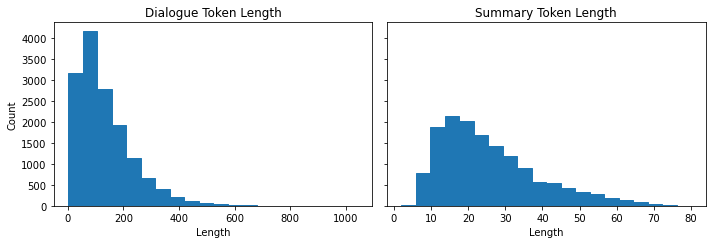

In [9]:
import matplotlib.pyplot as plt
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig,axes = plt.subplots(1,2,figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0",edgecolor = "C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len,bins=20,color="C0",edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

It's important to look at the length distribution of the dialogue (input) and summaries (output) before we train our model. We see that most dialogues are fairly short, containing around 100-200 tokens (a.k.a words) per dialogue. Similarly, summaries are shorter, with around 20-40 tokens (which you can compare to the average length of a tweet). 

Let's keep the observations from the EDA section in mind and build the data collator for the Trainer. First we need to tokenize the dataset. For now, we'll set the maximum lengths to 1024 and 128 for the dialogues and summaries, respectively:

In [10]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"],max_length=1024, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,truncation=True)
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

columns = ["input_ids","labels","attention_mask"]
dataset_samsum_pt.set_format(type="torch",columns=columns)

  0%|          | 0/1 [00:00<?, ?ba/s]

C:\Users\lwhieldon\AppData\Roaming\Python\Python39\site-packages\transformers\tokenization_utils_base.py:3542: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


A new thing in the use of the tokenization step is the `tokenizer.as_target_tokenizer()` context. Some models require special tokens in the decoder inputs, so it's important to differentiate between the tokenization of encoder and decoder iputs. In the `with` statement (called a _context manager_), the tokenizer knows that it is tokenizing for the decoder and can process sequences accordingly.

Now we need to create the data collator. This function is called in the `Trainer` just before the batch is fed through the model. In most cases we can use the default collator, which collects all the tensors from the batch and simply stacks them. For the summarization task we need to not only stack the inputs but also prepare the targets on the decoder side. PEGASUS is an encoder-decoder transformer and thus has the classic seq2seq architecture. In a seq2seq setup, a common approach is to apply "teacher forcing" in the decoder. With this strategy, the decoder receives input tokens (like in decoder-only models such as GPT-2) that consists of the labels shifted by one in additiona to the encoder output; so, when making the prediction for the next token the decoder gets the ground truth shifted by one as an input.

We shift it by one so that the decoder only see the previous group truth labels and not the current or future ones. Shifting alone suffices since the decoder has masked self-attention that masks all inputs at present and in the future.

So, when we prepare our batch, we set up the decoder inputs by shifting the labels to the right by one. After that, we make sure the padding tokens in the labels are ignored by the loss function by setting them to -100. We actually don't have to do this manually, though, since the `DataCollatorForSeq2Seq` comes to the rescue and takes care of all these steps for us:



In [11]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Then, as usual, we set up the `TrainingArguments` for training:

In [12]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir='pegasus-samsum',
                                  num_train_epochs=1,
                                  warmup_steps=500,
                                  per_device_train_batch_size=1,
                                  per_device_eval_batch_size=1,
                                  weight_decay=0.01,
                                  logging_steps=10,
                                  push_to_hub=True,
                                  evaluation_strategy='steps',
                                  eval_steps=500,
                                  save_steps=1e6,
                                  gradient_accumulation_steps=16
                            )

One thing that is different from the previous settings is that new argument, `gradient_accumulation_steps`. Since the model is quite big, we had to set the batch size to 1. However, a batch size that is too small can hurt convergence. To resolve the issue, we can use a nifty technique called _gradient accummulation_. As the name suggests, instead of calculating the gradients of the full batch all at once, we make smaller batches and aggregate the gradients. When we have aggregated enough gradients, we run the optimization step. Naturally, this is a bit slower than doing it in one pass, but it saves us a lot of GPU memory.

Let's now make sure that we are logged in to Hugging Face so we can push the model to the Hub after training:

In [20]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\lwhieldon/.huggingface/token


We now have everything we need to initialize the trainer with the model, tokenizer, training arguments, and data collator, as well as the training and evaluation sets:

In [14]:
trainer = Trainer(model=model,
                  args=training_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/Lwhieldon/pegasus-samsum into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/2.13G [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Download file spiece.model:   1%|1         | 24.0k/1.82M [00:00<?, ?B/s]

Clean file spiece.model:   0%|          | 1.00k/1.82M [00:00<?, ?B/s]

Clean file training_args.bin:  31%|###       | 1.00k/3.23k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/2.13G [00:00<?, ?B/s]

We are ready for training. After training, we can directly run the evaluation function on the test set to see how well the model performs:

In [15]:
trainer.train()
score = evaluate_summaries_pegasus(dataset_samsum["test"],
                                    rouge_metric,
                                    trainer.model,
                                    tokenizer,
                                    batch_size=2,
                                    column_text="dialogue",
                                    column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id. If summary, dialogue, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
C:\Users\lwhieldon\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920


  0%|          | 0/920 [00:00<?, ?it/s]

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 3.3369, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 2.8633, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 3.0138, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 2.901, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.9721, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.7123, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.6676, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.5026, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.5378, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.2458, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.2491, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.2101, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.0892, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.0286, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.1549, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 2.0327, 'learnin

The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id. If summary, dialogue, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


{'loss': 1.6776, 'learning_rate': 5e-05, 'epoch': 0.54}


  0%|          | 0/818 [00:00<?, ?it/s]

{'eval_loss': 1.4919248819351196, 'eval_runtime': 644.959, 'eval_samples_per_second': 1.268, 'eval_steps_per_second': 1.268, 'epoch': 0.54}
{'loss': 1.7402, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 1.6463, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 1.6937, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 1.6954, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 1.6894, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 1.6045, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 1.6103, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 1.5907, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 1.6141, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.64}
{'loss': 1.5658, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.65}
{'loss': 1.5725, 'learning_rate': 3.690476190476191e-05, 'epoch': 0.66}
{'loss': 1.5356, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.



Training completed. Do not forget to share your model on huggingface.co/models =)




{'loss': 1.5909, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 49392.0625, 'train_samples_per_second': 0.298, 'train_steps_per_second': 0.019, 'train_loss': 1.8225779782170834, 'epoch': 1.0}


100%|██████████| 410/410 [4:47:40<00:00, 42.10s/it]  


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.431695,0.201628,0.346877,0.347153


We see that the ROUGE scores improved considerably over the model without fine-tuning, so even though the previous model was also trained for summarization, it was not well adapted for the new domain. Let's push our model to the Hub:

In [16]:
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum\config.json
Model weights saved in pegasus-samsum\pytorch_model.bin
tokenizer config file saved in pegasus-samsum\tokenizer_config.json
Special tokens file saved in pegasus-samsum\special_tokens_map.json


Upload file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Lwhieldon/pegasus-samsum
   077cda2..b283db9  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Lwhieldon/pegasus-samsum
   077cda2..b283db9  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'config': 'samsum', 'split': 'train', 'args': 'samsum'}}
To https://huggingface.co/Lwhieldon/pegasus-samsum
   b283db9..bb71d4a  main -> main

   b283db9..bb71d4a  main -> main



'https://huggingface.co/Lwhieldon/pegasus-samsum/commit/b283db9bfedc624b8a0e54f250c20fe57e86a1c1'

# Model Inference

### Generating Dialogue Summaries

Looking at the losses and ROUGE score, it seems the model is showing a significant improvement over the original model trained on CNN/DailyMail only. Let's see what a summary generated on a sample from the test set looks like:

In [22]:
gen_kwargs = {"length_penalty":0.8,"num_beams":8, "max_length":128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization",model="Lwhieldon/pegasus-samsum",use_auth_token=True)


print("Dialogue")
print(sample_text)
print("\nReference Summary:")
print(reference)
print(pipe(sample_text,**gen_kwargs)[0]["summary_text"])

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

loading configuration file config.json from cache at C:\Users\lwhieldon/.cache\huggingface\hub\models--Lwhieldon--pegasus-samsum\snapshots\bb71d4a7aa1920d622d76980b3cf017d0f17eaf4\config.json
Model config PegasusConfig {
  "_name_or_path": "Lwhieldon/pegasus-samsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at C:\Users\lwhieldon/.cache\huggingface\hub\models--Lwhieldon--pegasus-samsum\snapshots\bb71d4a7aa1920d622d76980b3cf017d0f17eaf4\pytorch_model.bin
All model checkpoint weights were used when initializing PegasusForConditionalGeneration.

All the weights of PegasusForConditionalGeneration were initialized from the model checkpoint at Lwhieldon/pegasus-samsum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PegasusForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

loading file spiece.model from cache at C:\Users\lwhieldon/.cache\huggingface\hub\models--Lwhieldon--pegasus-samsum\snapshots\bb71d4a7aa1920d622d76980b3cf017d0f17eaf4\spiece.model
loading file tokenizer.json from cache at C:\Users\lwhieldon/.cache\huggingface\hub\models--Lwhieldon--pegasus-samsum\snapshots\bb71d4a7aa1920d622d76980b3cf017d0f17eaf4\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\lwhieldon/.cache\huggingface\hub\models--Lwhieldon--pegasus-samsum\snapshots\bb71d4a7aa1920d622d76980b3cf017d0f17eaf4\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\lwhieldon/.cache\huggingface\hub\models--Lwhieldon--pegasus-samsum\snapshots\bb71d4a7aa1920d622d76980b3cf017d0f17eaf4\tokenizer_config.json
Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.
Amanda can't find Betty's number. Larry called Betty's last time they were at the park together. Hannah wants Amanda to text him.


That looks much more like the reference summary. It seems the model has learned to synthesize the dialogue into a summary without just extracting passages. Now, the ultimate test: how well does the model work on custom input?

In [25]:
custom_dialogue = """\
 Lee: Hi guys, have you heard of our great professor, Zeanique Barber? 
 William: Yes, I was excited that she became our instructor for UMBC's DATA606 Capstone for Data Science in Fall 2022! 
 Lee: Indeed, she has amazing experience in Data Transformation for organizations and I'm excited to learn from her! 
 William: I know, I too have experience in Data Transformation in cloud technology ;) 
 Lee: Cool, maybe we should do a project about cloud data? What do you think? 
 William: Great idea, how hard can it be?! 
 William: I am in! 
 Lee: Awesome, let's do it together! 
"""
print("Dialogue")
print(custom_dialogue)
print("Inference Summary:")
print(pipe(custom_dialogue,**gen_kwargs)[0]["summary_text"])

Dialogue
 Lee: Hi guys, have you heard of our great professor, Zeanique Barber? 
 William: Yes, I was excited that she became our instructor for UMBC's DATA606 Capstone for Data Science in Fall 2022! 
 Lee: Indeed, she has amazing experience in Data Transformation for organizations and I'm excited to learn from her! 
 William: I know, I too have experience in Data Transformation in cloud technology ;) 
 Lee: Cool, maybe we should do a project about cloud data? What do you think? 
 William: Great idea, how hard can it be?! 
 William: I am in! 
 Lee: Awesome, let's do it together! 

Inference Summary:
Zeanique Barber will be the instructor for the DATA606 Capstone for Data Science in Fall 2022 at UMBC. Lee and William want to do a project about cloud data.


The generated summary of the custom dialogue makes sense. It summarizes well that all the people in the discussion want to write the book together and does not simply extract single sentences. 

# Conclusions & Limitations
